## Import

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
rng = np.random.default_rng(123456)

import librosa
import librosa.display
import IPython.display as ipd
import copy
from scipy.io import wavfile
import random

import os
from sklearn import neighbors

## AudioDataset class

In [12]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, active='wavs', normalize=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.labels = []
        self.min_val = 10e10
        self.max_val = 0
        self.normalize = normalize
        self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths = [], [], [], [], [], []
        self.wavs_norm, self.mfccs_norm, self.chromas_norm, self.contrasts_norm, self.centroids_norm, self.bandwidths_norm = [], [], [], [], [], []
        
        print("Start reading files and genearting features")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                self.feature_extraction(wav, self.sample_rate)
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)

        self.active = active
        self.values_dict = {'wavs': 0, 'mfcc': 1, 'chroma': 2, 'contrast': 3, 'centroid': 4, 'bandwidth': 5}
        self.values_list = [self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths]
        self.values_norm_list = []
        print("Generating normalized arrays")
        for lst in self.values_list:
            self.values_norm_list.append((lst + np.abs(np.min(lst))) / (np.abs(np.min(lst)) + np.max(lst)))
            
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\n".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std))
        print("="*40)

    def feature_extraction(self, wav, sample_rate):
        self.mfccs.append(np.transpose(np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=128).T, axis=0)))
        # self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_cqt(y=wav, sr=sample_rate).T, axis=0)))
        self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_stft(y=wav, sr=sample_rate).T, axis=0)))
        self.contrasts.append(np.transpose(np.mean(librosa.feature.spectral_contrast(y=wav, sr=sample_rate).T, axis=0)))
        self.centroids.append(np.transpose(np.mean(librosa.feature.spectral_centroid(y=wav, sr=sample_rate).T, axis=0)))
        self.bandwidths.append(np.transpose(np.mean(librosa.feature.spectral_bandwidth(y=wav, sr=sample_rate).T, axis=0)))

    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        x = self.values_list[self.values_dict[self.active]][idx]
        if self.normalize:
            x = self.values_norm_list[self.values_dict[self.active]][idx]
        x = torch.Tensor(x)
        return x, y


## Loading data for training

In [13]:
audio_dataset = AudioDataset(root_path="../data/", drop_both=False, use_short=False)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

Start reading files and genearting features


KeyboardInterrupt: 

## Prepare data

In [ ]:
kwargs = {'batch_size': 1, 'num_workers': 1}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

## Prepare data for knn

In [ ]:
train_size, test_size = round(dataset_len * 0.8), round(dataset_len * 0.2)
dataset_train, dataset_test = torch.utils.data.random_split(audio_dataset, (train_size, test_size))
kwargs = {'batch_size': 1, 'num_workers': 1}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
train_data = []
train_labels = []
test_data = []
test_labels = []
lists_data = [train_data, test_data]
lists_labels = [train_labels, test_labels]

i = 0
for loader in [loader_train, loader_test]:
    for x, y in loader:
        lists_data[i].append(np.array(x[0]))
        lists_labels[i].append(np.array(y[0]))
    i += 1
for li in lists_data:
    print(len(li))
for li in lists_labels:
    print(len(li))

## Visualize data

In [ ]:
audio_dataset.active = 'wavs'
audio_dataset.normalize = False

for x, y in loader_test:
    plt.plot(np.arange(x.shape[1]), x.flatten())
    plt.show()
    break

## Autoencoder class

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_len, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, input_len),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        return self.decode(self.encode(x))

## Training autoencoder

In [ ]:
model = AutoEncoder(len(dataset_train[0][0]))
opt = torch.optim.Adam(model.parameters())

for epoch in range(25):
    print(f'Epoch {epoch+1:02}/25', end=' ')
    for x, _ in loader_train:  
        x_rec = model(x) 
        loss = F.binary_cross_entropy(x_rec, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        mse = F.mse_loss(x_rec, x)
        mae = F.l1_loss(x_rec, x)
        
    print(f'loss: {loss.item():.4f} - rmse: {np.sqrt(mse.item()):.4f} - mae: {mae.item():.4f}')

## Define KNN

In [ ]:
def knn_param_search(train_data, train_labels, test_data, test_labels,
                     metrics=('manhattan', 'euclidean', 'chebyshev'), 
                     ks=(1, 3, 5, 10, 25, 50, 100, 250), 
                     n_train=None, n_test=None, algorithm='brute'):
  """
  Takes a dataset and plots knn classification accuracy 
  for different hyper parameters.

  n_train and n_test allows to subsample the dataset for faster iteration
  """
  x_train = np.array(train_data)
  y_train = np.array(train_labels)
  x_test = np.array(test_data)
  y_test = np.array(test_labels)
  max_acc = 0
  datas = []
  for metric in metrics:
    for k in ks:
        print(f'Metric: {metric}; k: {k:3};', end=' ')
        classifier = neighbors.KNeighborsClassifier(k, algorithm=algorithm, metric=metric)
        classifier = classifier.fit(x_train, y_train)

        labels = classifier.predict(x_test)
        
        correct = labels == np.array(y_test)
        print(f'Accuracy: {correct.mean() * 100:.2f}%')
        if correct.mean() > max_acc:
          max_acc = correct.mean()
          best_classifier = classifier
          best_metric = metric
          best_k = k
        datas.append([metric, k, correct.mean()])
      
  print(f'Best classifier | metric: {best_metric}; k: {best_k:3}; accuracy: {max_acc * 100:.2f}%')
  return best_classifier, datas

## Call KNN

In [ ]:
with open('../data/knn_results.txt', 'w') as f:
  for norm_opt in [False, True]:
    audio_dataset.normalize = norm_opt
    for feature in ['wavs', 'mfcc', 'chroma', 'contrast']:
      audio_dataset.active = feature
      
      train_data = []
      train_labels = []
      test_data = []
      test_labels = []
      lists_data = [train_data, test_data]
      lists_labels = [train_labels, test_labels]
      i = 0
      for loader in [loader_train, loader_test]:
          for x, y in loader:
              lists_data[i].append(np.array(x[0]))
              lists_labels[i].append(np.array(y[0]))
          i += 1

      classifier, datas = knn_param_search(train_data, 
                                    train_labels, 
                                    test_data,
                                    test_labels,
                                  #   metrics=['euclidean'],
                                    ks=(1, 3, 5, 10, 25, 50, 100))
      f.write(f'Norm:{norm_opt};feature:{feature};{datas}\n')

## Old plot KNN

In [ ]:
no_norm_no_feat = [43.00, 50.00, 50.00, 50.00, 51.00, 51.00, 50.00, 50.00, 50.00, 47.00, 49.00, 50.00, 50.00, 50.00, 50.00, 50.00, 45.00, 48.00, 49.00, 54.00, 50.00, 53.00, 54.00, 52.00]
norm_no_feat = [50.00, 49.00, 58.00, 57.00, 59.00, 54.00, 57.00, 59.00, 52.00, 54.00, 57.00, 57.00, 45.00, 57.00, 57.00, 57.00, 46.00, 45.00, 47.00, 44.00, 51.00, 59.00, 59.00, 60.00]
norm_feat = [77.00, 78.00, 72.00, 68.00, 71.00, 73.00, 70.00, 58.00, 78.00, 78.00, 76.00, 78.00, 78.00, 81.00, 76.00, 64.00, 81.00, 85.00, 84.00, 81.00, 81.00, 73.00, 74.00, 75.00]
no_norm_feat = [88.00, 90.00, 93.00, 88.00, 84.00, 85.00, 83.00, 80.00, 83.00, 89.00, 87.00, 82.00, 83.00, 81.00, 77.00, 70.00, 77.00, 76.00, 76.00, 80.00, 76.00, 75.00, 71.00, 61.00]
datas = [no_norm_no_feat ,norm_no_feat ,norm_feat ,no_norm_feat]
titles = ['Norm=False; Features=False' ,'Norm=True; Features=False', 'Norm=True; Features=True', 'Norm=False; Features=True']
ks = [1, 3, 5, 10, 25, 50, 100, 250]
metrics = ['manhattan', 'euclidean', 'chebyshev']

fig = plt.figure(figsize=(28, 16))
for i, data in enumerate(datas):
    # fig = plt.figure(figsize=(32,4))
    ax = fig.add_subplot(2, 2, i+1)
    
    fig.tight_layout()
    ax.title.set_text(titles[i])
    tmp = []
    for j in range(len(ks)):
        tmp.append(data[j])
        tmp.append(data[j+len(ks)])
        tmp.append(data[j+len(ks)*2])
        tmp.append(0)
    tmp.pop()
    clrs = ('blue', 'red', 'green') * len(ks)

    bars = plt.bar(range(len(tmp)), tmp, width=0.8, color=clrs)
    for bar in bars:
        if bar.get_height() > 0:
            ax.text(bar.get_x(), bar.get_height(), format(int(bar.get_height())))

    ax.set_ylim(0, 100)
    ax.set_ylabel('accuracy')

    ax.set_xticks(range(len(tmp)))
    x_tick_labels = []
    for k in ks:
        x_tick_labels.append('')
        x_tick_labels.append(format(k))
        x_tick_labels.append('')
        x_tick_labels.append('')
    x_tick_labels.pop()
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel('K')

    if i == 0:
        legend_patches = [mpatches.Patch(color=clrs[0], label=metrics[0]), mpatches.Patch(color=clrs[1], label=metrics[1]), mpatches.Patch(color=clrs[2], label=metrics[2])]
        plt.legend(handles=legend_patches)
    # plt.show()
plt.show()

## Build MLP

In [ ]:
# by extending nn.Module:
class MLP(nn.Module):
  def __init__(self, n_hidden_neurons: int, input_len):
    super().__init__()
    self.fc1 = nn.Linear(input_len, n_hidden_neurons)
    self.fc2 = nn.Linear(n_hidden_neurons, 2)

  def forward(self, x: torch.Tensor):
    # x = x.flatten(start_dim=0)  # (N, d_data)
    h = F.relu(self.fc1(x))
    logits = self.fc2(h)
    return logits

## Train MLP

In [ ]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None
learning_rate = 5e-2
n_epochs = 10

for n_hidden_neurons in ([10, 100, 1000, 10000]):
  print(f"Hidden neurons: {n_hidden_neurons}")
  model = MLP(n_hidden_neurons, len(dataset_train[0][0]))
  opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  for epoch in range(n_epochs):
    print(f"{epoch+1:02} / 10 Epoch", end=": ")

    epoch_losses = []
    correct, total = 0, 0
    for x, y in loader_train:
      opt.zero_grad()
  
      logits = model(x)  # logits: common name for the output before softmax activation
  
      log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
  
      loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
      # or just: loss = F.cross_entropy(logits, y)

      loss.backward()
      opt.step()
      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(correct / total)
    print(f"Train; Loss mean: {np.mean(epoch_losses):2.2f}; Accuracy: {correct / total:2.2f}", end=" | ")
    
    epoch_losses = []
    correct, total = 0, 0
    for x, y in loader_valid:
      with torch.no_grad():
        logits = model(x)
      loss = F.cross_entropy(logits, y)

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    valid_losses.append(np.mean(epoch_losses))
    valid_accuracy = correct / total
    valid_accuracies.append(valid_accuracy)
    print(f"Valid; Loss mean: {np.mean(epoch_losses):2.2f}; Accuracy: {valid_accuracy:2.2f}")
    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  all_losses[n_hidden_neurons] = train_losses, valid_losses
  all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

## Results from MLP

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# test
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

correct, total = 0, 0
for x, y in loader_valid:
  with torch.no_grad():
    logits = model(x)
  total += len(x)
  correct += (torch.argmax(logits, dim=1) == y).sum().item()
print(f'test accuracy: {correct / total:.2f}')

## LSTM MIMO

In [ ]:
class OnlineClassifier(nn.Module):
    def __init__(self, input_size, n_lstm_layers=1, dropout=0.):
        super().__init__()
        # self.emb = nn.Embedding(128, d)  # max(emails_ascii) < 128
        self.lstm = nn.LSTM(input_size, input_size, n_lstm_layers, batch_first=False, dropout=dropout)
        self.lin = nn.Linear(input_size, 1)

    def forward(self, x, end_idx):  # (B, nx)
        # x = self.emb(x)  # (B, nx, d)
        # y = self.lstm(x)[0][torch.arange(len(x)), end_idx]  # (B, d)
        y = self.lstm(x)
        return y
        # return self.lin(y).view(-1)  # (B,)

In [ ]:
device = torch.device('cuda')

model = OnlineClassifier(audio_dataset.max_length).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
lrs = []
epochs = 40

for epoch in range(epochs):
    print(f"{epoch+1:02} / 10 Epoch", end=": ")
    # train
    model.train()
    losses = []
    correct = total = 0
    for x, end_idx, y in loader_train:
        x, end_idx, y = x.to(device), end_idx.to(device), y.to(device)
        logits = model(x, end_idx)

        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        correct += ((torch.sigmoid(logits) > 0.5) == y).sum().item()
        total += len(x)
    train_loss = np.mean(losses)
    train_acc = correct / total

    # valid
    model.eval()
    losses = []
    correct = total = 0
    for x, end_idx, y in loader_valid:
        x, end_idx, y = x.to(device), end_idx.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x, end_idx)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        losses.append(loss.item())
        correct += ((torch.sigmoid(logits) > 0.5) == y).sum().item()
        total += len(x)
    valid_loss = np.mean(losses)
    valid_acc = correct / total

    # sched
    sched.step()
    
    # history
    lrs.append(next(iter(opt.param_groups))['lr'])

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    print(f'loss: {train_loss:.3f}/{valid_loss:.3f}, acc: {train_acc:.2f}/{valid_acc:.2f}')

# plot history
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(train_losses, label='train')
axs[0].plot(valid_losses, label='valid')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accuracies, label='train')
axs[1].plot(valid_accuracies, label='valid')
axs[1].set_ylabel('acc')
axs[1].set_ylim(0.8, 1)
axs[1].legend()
axs[2].plot(lrs)
axs[2].set_ylabel('lr')
axs[2].set_yscale('log')
plt.tight_layout()
plt.show()

## Plot from KNN

In [23]:
def plot_function_knn(file_name, folder_name=None, showing=True):
    if not showing:
        print("Plotting is off")
        plt.ioff()
    if folder_name == None:
        folder_name = '../output/' + file_name.split('/')[-1].replace('.txt', '')
    folder_name += '_' + str(round(random.random()*1e4)) + '/'    
    width = 0.8
    if 'long' in file_name:
        ks=(1, 3, 5, 10, 25, 50, 100)
    else:
        ks=(1, 3, 5, 10, 25, 50, 100, 250)
    metrics = ['manhattan', 'euclidean', 'chebyshev']
    color_dict = {'manhattan':'firebrick', 'euclidean':'dodgerblue', 'chebyshev':'seagreen'}
    os.mkdir(folder_name)

    with open(file_name) as f:
        lines = f.readlines()
        for line in lines:
            norm_str = line.split(';')[0]
            feature_str = line.split(';')[1]
            data_list = line.split(';')[2].replace('[', '').replace(']', '').replace('\'', '').replace(' ', '').split(',')
            fig = plt.figure(figsize=(10, 5))
            fig.suptitle(norm_str + ' ' + feature_str)
            ax = fig.add_subplot()

            fig.tight_layout()
            i = 0
            x_pos = {1: 0, 3: 3, 5: 6, 10: 9, 25: 12, 50: 15, 100: 18, 250:21}
            while i < (len(data_list) -2):
                metric = data_list[i]
                k = int(data_list[i+1])
                acc = float(data_list[i+2])
                i += 3
                plt.bar(x_pos[k], acc-0.01, width=width, color=color_dict[metric])
                ax.text(x_pos[k]-0.5, acc, '{0:.2f}'.format(acc))
                x_pos[k] += 1
                
            x_tick_labels = []
            for k in ks:
                x_tick_labels.append('')
                x_tick_labels.append(format(k))
                x_tick_labels.append('')
                
            ax.set_yticks(np.arange(0, 1, 0.1))
            ax.set_xticks(range(len(x_tick_labels)))
            ax.set_xticklabels(x_tick_labels)

            ax.set_ylabel('accuracy')
            ax.set_xlabel('K')

            legend_patches = []
            for metric in color_dict:
                legend_patches.append(mpatches.Patch(color=color_dict[metric], label=metric))
            plt.legend(handles=legend_patches)
            plt.savefig(folder_name + norm_str.replace(':', '_') + '_' + feature_str.replace(':', '_') + '.png')
            if showing:
                plt.show()
            plt.clf()
    if not showing:
        plt.ion()
    plt.close("all")



## Plotting function LSTM/MLP

In [2]:
def plot_function_lstm_mlp(file_name, folder_name=None, showing=True):
    if not showing:
        print("Plotting is off")
        plt.ioff()
    if folder_name == None:
        folder_name = '../output/' + file_name.split('/')[-1].replace('.txt', '')
    folder_name += '_' + str(round(random.random()*1e4)) + '/'
    test_acc = {}
    os.mkdir(folder_name)
    with open(file_name) as  f:
        lines = f.readlines()
        for i in range(len(lines)):
            line_list = lines[i].split(":")
            if len(line_list) == 3:
                fig = plt.figure(figsize=(8, 4))
                title_str = lines[i].replace('\n', '').replace('Norm', '').replace('Feature', '').replace(':', '').replace(',', '_').replace(' ', '')
                fig.suptitle(title_str)
                
                train_losses = np.array(lines[i+1].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                train_accuracies = np.array(lines[i+2].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                valid_losses = np.array(lines[i+3].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                valid_accuracies = np.array(lines[i+4].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                test_acc[lines[i]] = float(lines[i+5].split(':')[1])
                test_acc_line =np.full((valid_losses.shape), test_acc[lines[i]])
                i += 5
                
                plt.subplot(1, 2, 1)
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.plot(train_losses,  label='train', c='blue')
                plt.plot(valid_losses,  label='valid', c='green')
                plt.legend()
                plt.grid()

                plt.subplot(1, 2, 2)
                plt.xlabel('epoch')
                plt.ylabel('accuracy')
                plt.ylim(0, 1)
                plt.yticks(np.linspace(0, 1, 10))
                
                plt.plot(train_accuracies, label='train', c='blue')
                plt.plot(valid_accuracies, label='valid', c='green')
                plt.plot(test_acc_line, label='test', ls='--', c='red')
                plt.legend()
                plt.grid()

                plt.tight_layout()
                plt.savefig(folder_name + title_str + '.png')
                if showing:
                    print('showing')
                    plt.show()

        fig = plt.figure(figsize=(10,5))
        fig.suptitle('Test accuracy comparison')
        
        clrs = clrs = plt.cm.rainbow(np.linspace(0, 1, 8))

        ax = fig.add_subplot()
        bars = plt.bar(range(len(test_acc)), list(test_acc.values()), hatch=['/', '/', '/', '/', '', '', '', ''], width=0.8, color=clrs)
        
        xlabels = []
        for bar, feature in zip(bars, test_acc):
            if bar.get_height() > 0:
                feature_string = feature.replace(':','').replace(', Feature', '').replace(' ', '').replace('Norm', '').replace('False', '').replace('True', '')
                if 'False' in feature_string:
                    feature_string = feature_string.replace('Norm', '').replace('False', '')
                else:
                    feature_string = feature_string.replace('True', '')
                ax.text(bar.get_x(), bar.get_height() + 0.01, "{0:.5f}".format(bar.get_height()))
                xlabels.append(feature_string.capitalize())
        
        ax.set_yticks(np.arange(0, 1, 0.1))
        ax.set_xticks(range(len(xlabels)))
        ax.set_xticklabels(xlabels)
        
        legend_patches = [mpatches.Patch(hatch='///', edgecolor='black', fill=False, label='normalized')]
        plt.legend(handles=legend_patches)
        
        plt.savefig(folder_name + 'test_acc.png')
        if showing:
            plt.show()
        if not showing:
            plt.ion()
        plt.close("all")

## Call plotting function

In [76]:
plot_function_knn('../output/results_short_both_KNN.txt', folder_name=None, showing=False)
plot_function_knn('../output/results_long_both_KNN.txt', folder_name=None, showing=False)
plot_function_lstm_mlp('../output/results_short_MLP.txt', folder_name=None, showing=False)
plot_function_lstm_mlp('../output/results_long_both_MLP.txt', folder_name=None,showing=False)
plot_function_lstm_mlp('../output/results_long_both_LSTM.txt', folder_name=None,showing=False)
# plot_function_lstm_mlp('../output/results_short_hyp_MLP.txt', folder_name=None, showing=False)

Plotting is off
Plotting is off
Plotting is off
Plotting is off
Plotting is off


In [19]:
def find_best_net(file_name):
    #plt.ioff()
    # folder_name += '_' + str(round(random.random()*1e4)) + '/'
    test_acc = {}
    # os.mkdir(folder_name)
    with open(file_name) as  f:
        lines = f.readlines()
        for i in range(len(lines)):
            line_list = lines[i].split(":")
            if len(line_list) == 6:
                # fig = plt.figure(figsize=(8, 4))
                title_str = lines[i]
                title_str = lines[i].replace('\n', '').replace('Norm', '').replace('Feature', '').replace(':', '_').replace(',', '_').replace(' ', '')
                # fig.suptitle(title_str)
                
                train_losses = np.array(lines[i+1].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                train_accuracies = np.array(lines[i+2].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                valid_losses = np.array(lines[i+3].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                valid_accuracies = np.array(lines[i+4].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
                test_acc[lines[i]] = float(lines[i+5].split(':')[1])
                test_acc_line =np.full((valid_losses.shape), test_acc[lines[i]])
                i += 6
        i = 0
        max_v = 0
        
        fig = plt.figure(figsize=(16,4))
        hidden_neurons = {10:'red', 100:'green', 500:'blue', 1000:'black'}
        learning_rates = {0.01:'red', 0.001:'green', 0.0001: 'blue'}
        batch_sizes = {1: 'red', 8: 'green', 32: 'blue', 128: 'black'}
        n_layers = {2: 'red', 4: 'green', 6: 'blue'}
        for net in test_acc:
            layers = int(net.split(',')[0].split(':')[1].replace(' ', ''))
            neurons = int(net.split(',')[1].split(':')[1].replace(' ', ''))
            lr = float(net.split(',')[2].split(':')[1].replace(' ', ''))
            batch_size = int(net.split(',')[3].split(':')[1].replace(' ', ''))
            if test_acc[net] > .0:
                plt.bar(i, (test_acc[net]), color=hidden_neurons[neurons])
                i+=1
            if float(test_acc[net]) > max_v:
                max_v = test_acc[net]
                best_net = net
        print("best:", test_acc[best_net], best_net)
                

In [20]:
print("MLP_long_best:")
find_best_net('../output/last_MLP/results_long_hyp_MLP.txt')

print("LSTM_long_best:")
find_best_net('../output/results_long_hyp_LSTM.txt')

print("MLP_short_best:")
find_best_net('../output/last_MLP/results_short_hyp_MLP.txt')

print("LSTM_short_best:")
find_best_net('../output/results_short_hyp_LSTM.txt')

MLP_long_best:
best: 0.8166666666666667 N_layers: 2, N_hidden_neurons: 1000, LR: 0.0001, Batch_size: 8, Epochs: 50

LSTM_long_best:
best: 0.9 N_layers: 2, N_hidden_neurons: 500, LR: 0.001, Batch_size: 8, Epochs: 50

MLP_short_best:
best: 0.9504950495049505 N_layers: 2, N_hidden_neurons: 100, LR: 0.0001, Batch_size: 8, Epochs: 50

LSTM_short_best:
best: 0.95 N_layers: 4, N_hidden_neurons: 1000, LR: 0.0001, Batch_size: 8, Epochs: 50



best: 0.9504950495049505 N_layers: 2, N_hidden_neurons: 100, LR: 0.0001, Batch_size: 8, Epochs: 50



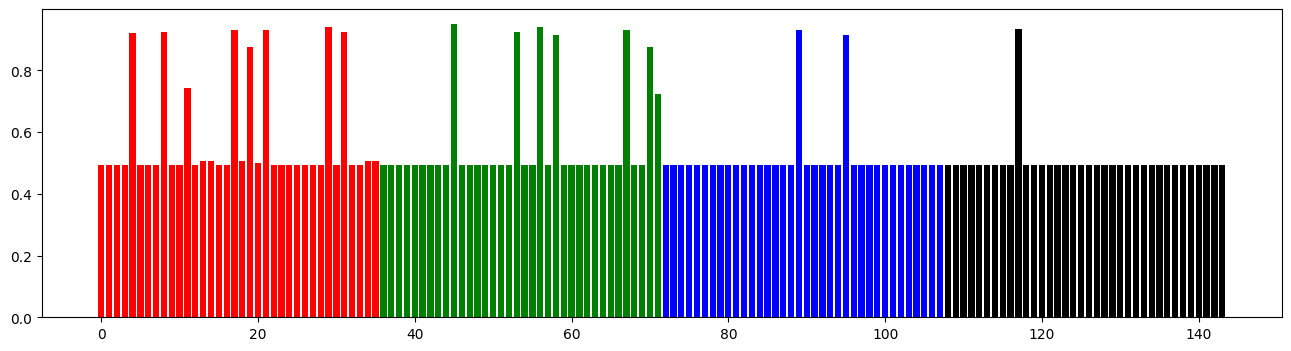